In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train = train.drop_duplicates()

train,val = train_test_split(train,train_size=0.7,random_state=0)

y_train = train.Survived
X_train = train.drop(columns='Survived')

X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
857,858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
52,53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
386,387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
124,125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
578,579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
192,193,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
629,630,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
559,560,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,NaN,S


In [124]:
nullcnt = X_train.isnull().sum()

nullcnt = nullcnt[nullcnt>0].apply(lambda x: x/X_train.shape[0]).sort_values(ascending=False)

null_col = nullcnt[nullcnt>0.3].index

X_train = X_train.drop(columns=null_col)

nullcnt

Cabin       0.756019
Age         0.194222
Embarked    0.003210
dtype: float64

In [125]:
X_train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [126]:
X_train[X_train.select_dtypes(exclude=np.number).columns].apply(lambda x: x.unique())

Name        [Daly, Mr. Peter Denis , Harper, Mrs. Henry Sl...
Sex                                            [male, female]
Ticket      [113055, PC 17572, CA 2144, 35281, 2689, C.A. ...
Embarked                                       [S, C, Q, nan]
dtype: object

In [127]:
X_train.Name.apply(lambda x: x.split('.')[0].split()[-1]).value_counts()

Mr          367
Miss        121
Mrs          88
Master       31
Rev           3
Dr            3
Mlle          2
Major         2
Ms            1
Mme           1
Countess      1
Lady          1
Capt          1
Sir           1
Name: Name, dtype: int64

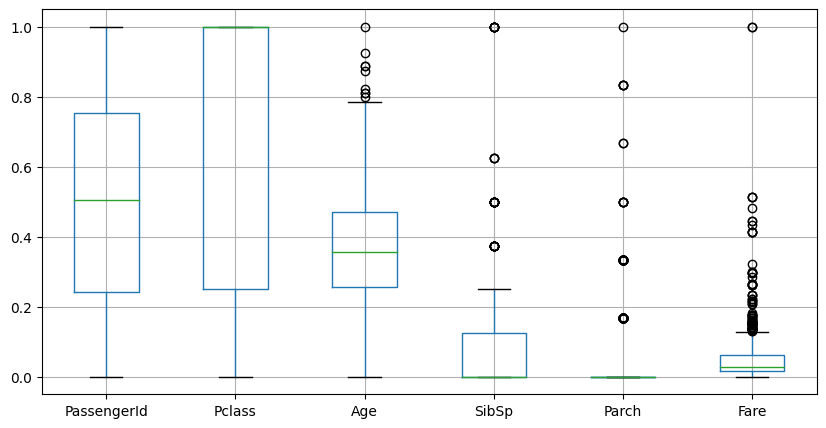

In [128]:
fig,ax = plt.subplots(figsize=(10,5))

numcol_train = X_train.select_dtypes(include=np.number)

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(numcol_train), columns=numcol_train.columns)

boxdf.boxplot()

plt.show()

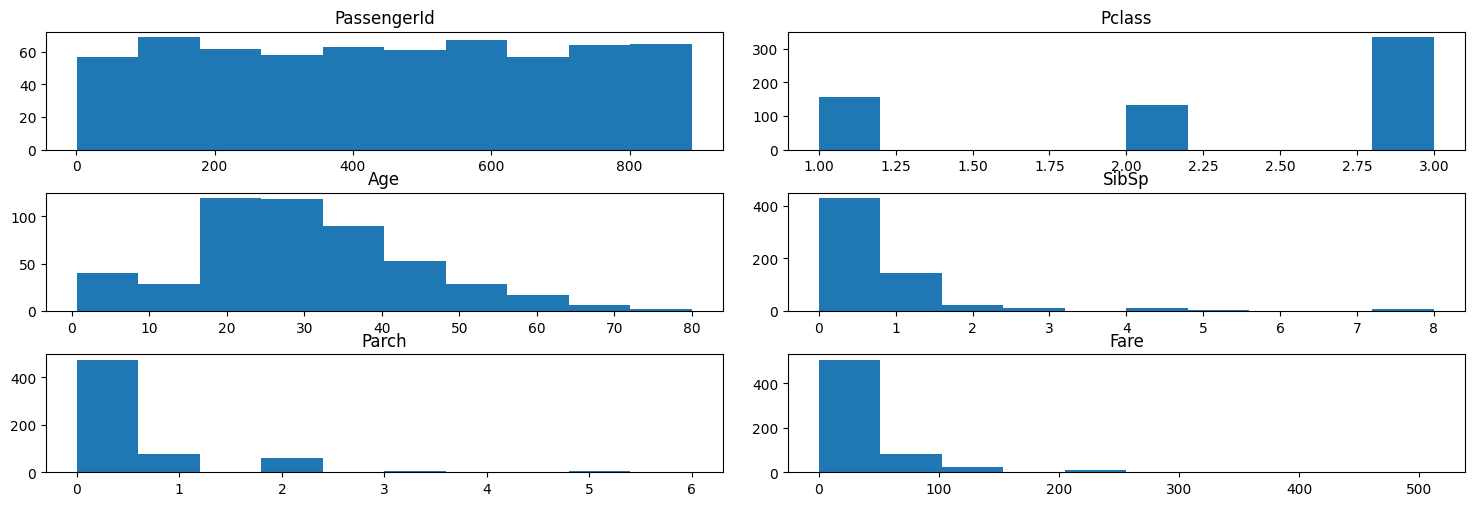

In [129]:
fig,ax = plt.subplots(3,2,figsize=(15,5))
ax = ax.flatten()
fig.tight_layout(w_pad=1, h_pad=1)

for ind,col in enumerate(numcol_train):
    ax[ind].hist(X_train[col])
    ax[ind].set_title(col)
    
plt.show()

In [130]:
X_id = X_train.PassengerId
X_train = X_train.drop(columns='PassengerId')

In [131]:
y_train.value_counts()

0    381
1    242
Name: Survived, dtype: int64

# Imputation and Encoding

In [132]:
class CustomTransformer(TransformerMixin, BaseEstimator): 
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        self.X = X
        
        X_transformed = X.applymap(lambda x: x.split('.')[0].split()[-1])
        X_transformed = X_transformed.applymap(lambda x: x.replace('Mlle','Miss').replace('Ms','Miss').replace('Mme','Mrs'))
        
        return X_transformed
    
    def get_feature_names_out(self, _):
        return ['' for i in range(len(self.X.columns))]
    

class CustomTransformer2(TransformerMixin, BaseEstimator): 
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        self.X = X
        
        X_transformed = X.applymap(lambda inp: "".join(filter(lambda x: not x.isdigit(), inp)).upper() + ' num')
        X_transformed = X_transformed.applymap(lambda inp: ' '.join(inp.replace('/',' ').replace('.','').split()))
        
        return X_transformed
    
    def get_feature_names_out(self, _):
        return self.X.columns.tolist()

    
num_pipe = Pipeline([
    ('numimp',SimpleImputer(strategy='median'))
])

ordcol_pipe = Pipeline([
    ('ordcolimp',SimpleImputer(strategy='most_frequent')),
    ('ordcolenc',OrdinalEncoder())
])

nomcol_pipe1 = Pipeline([
    ('nomcolimp1',SimpleImputer(strategy='most_frequent')),
    ('nomcoltf',CustomTransformer()),
    ('nomcolenc1',OneHotEncoder(handle_unknown='ignore'))
])

nomcol_pipe2 = Pipeline([
    ('nomcolimp2',SimpleImputer(strategy='most_frequent')),
    ('nomcolenc2',OneHotEncoder())
])

nomcol_pipe3 = Pipeline([
    ('nomcolimp3',SimpleImputer(strategy='most_frequent')),
    ('nomcoltf2',CustomTransformer2())
])

preproc_pipeline = ColumnTransformer([
    ('num',num_pipe,X_train.select_dtypes(include=np.number).columns),
    ('ordcol',ordcol_pipe,['Sex']),
    ('nomcol1',nomcol_pipe1,['Name']),
    ('nomcol2',nomcol_pipe2,['Embarked']),
    ('nomcol3',nomcol_pipe3,['Ticket'])
])

In [133]:
def preproc_func(X,mode='train'):
    
    if mode=='train':
        preproc_pipeline.fit(X)
    X_proc = pd.DataFrame(preproc_pipeline.transform(X), 
                          columns=preproc_pipeline.get_feature_names_out())
    
    
    hasher = HashingVectorizer(n_features=2**4, lowercase=False)
    if mode=='train':
        hasher.fit(X_proc.iloc[:,-1])
    hashed = pd.DataFrame(hasher.transform(X_proc.iloc[:,-1]).toarray(), 
                          columns=[f'Ticket_{i}' for i in range(2**4)])
    
    
    X_proc = pd.concat([X_proc.iloc[:,:-1],hashed], axis=1).astype(np.float64)
    
    X_proc['num__nbrel'] = X_proc.num__SibSp + X_proc.num__Parch
    X_proc = X_proc.drop(columns=['num__SibSp','num__Parch'])

    return X_proc

X_proc = preproc_func(X_train)

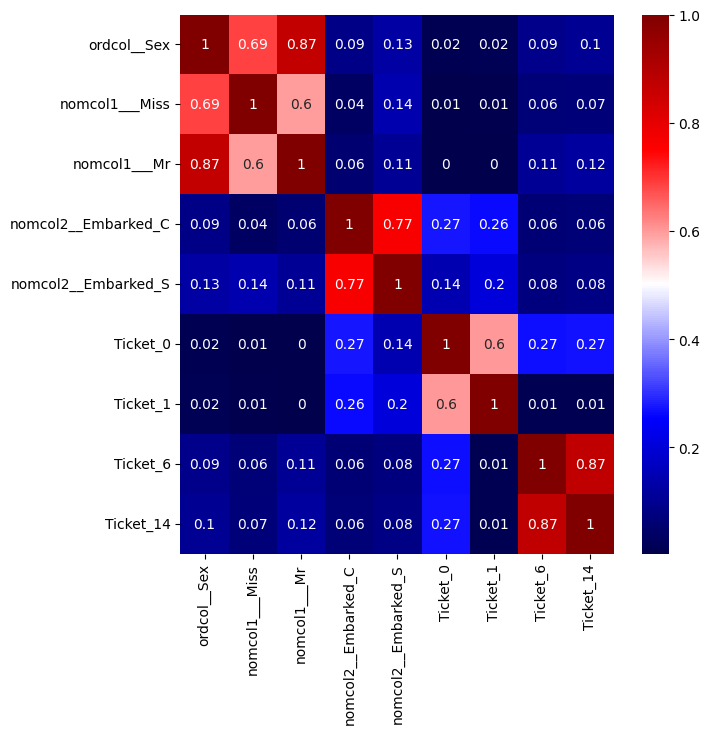

In [134]:
fig,ax = plt.subplots(figsize=(7,7))

corrdf = X_proc.corr().abs()

high_corr_col = corrdf[corrdf.applymap(lambda x: True if (x>=0.6) and (x<1) else False).sum() > 0].index
corrdf_small = corrdf.loc[high_corr_col,high_corr_col]

sns.heatmap(corrdf_small,annot=np.round(corrdf_small,2),cmap='seismic')

plt.show()

In [135]:
zero_cols = X_proc.loc[:, ~(X_proc != 0).any(axis=0)].columns
X_proc = X_proc.drop(columns=[*['ordcol__Sex','Ticket_14'],*zero_cols])

# Scaling and Oversampling

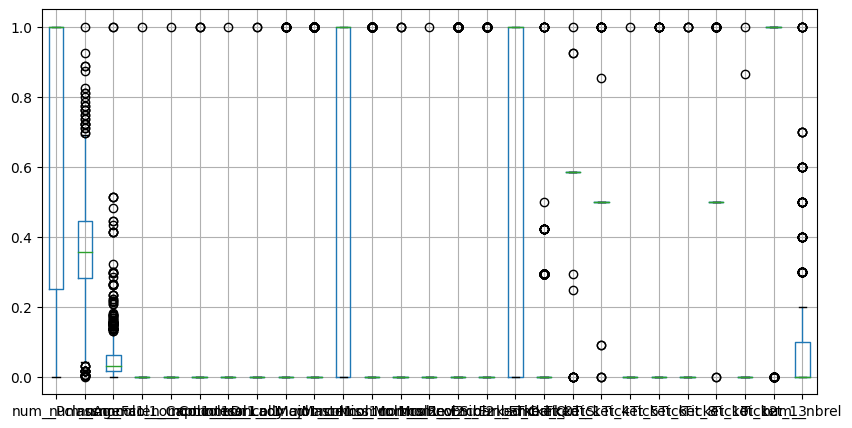

In [137]:
fig,ax = plt.subplots(figsize=(10,5))

numcol_train = X_proc.select_dtypes(include=np.number)

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(numcol_train), columns=numcol_train.columns)

boxdf.boxplot()

plt.show()

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


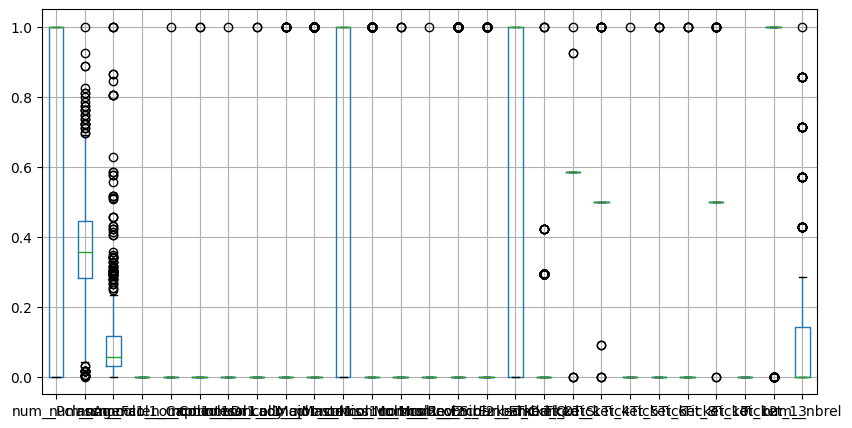

In [139]:
def outlier_removal(X):
    X_or = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X),columns=X.columns)
    isoforest = IsolationForest(contamination=0.05, random_state=0)
    
    stddf = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns).std().sort_values()
    
    outpred = pd.DataFrame(isoforest.fit_predict(X_or[stddf.head(20).index]))
    inlieind = outpred.loc[outpred[0] == 1].index
    
    X = X.iloc[inlieind]
    return X, inlieind

X_proc_or,index = outlier_removal(X_proc)
y_proc_or = y_train.iloc[index]

fig,ax = plt.subplots(figsize=(10,5))

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(X_proc_or),columns=X_proc_or.columns)

boxdf.boxplot()

plt.show()

In [140]:
scaler = RobustScaler()
scaler.fit(X_proc_or)
X_proc_or = scaler.transform(X_proc_or)

In [143]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_proc_or, y_proc_or)

y_res.value_counts()

1    362
0    362
Name: Survived, dtype: int64

In [146]:
X_res = pd.DataFrame(X_res,columns=X_proc.columns)
X_res

,num__Pclass,num__Age,num__Fare,nomcol1___Capt,nomcol1___Countess,nomcol1___Dr,nomcol1___Lady,nomcol1___Major,nomcol1___Master,nomcol1___Miss,...,Ticket_0,Ticket_1,Ticket_4,Ticket_5,Ticket_6,Ticket_8,Ticket_10,Ticket_12,Ticket_13,num__nbrel
0,-1.00000,1.692308,0.535805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,-1.00000,1.538462,2.758583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.707107,1.000000
2,-1.00000,1.923077,2.783313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
3,0.00000,0.000000,0.000182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
4,0.00000,-0.692308,-0.283685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,-0.13978,-0.713812,-0.257335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.211012,0.0,0.509428,0.0,0.0,0.0,0.0,0.0,0.000000,0.720440
720,-0.50000,0.510083,0.967098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.116506
721,-1.00000,0.077625,1.675451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
722,0.00000,0.743962,-0.289223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292893,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


# Model

In [152]:
grid = {'penalty':['l1','l2','elasticnet'], 
        'C':[10**i for i in range(-6,3)], 
        'l1_ratio':[0.1*i for i in range(0,11)]}

model = LogisticRegression(max_iter=2000,solver='saga')

grid_cv = GridSearchCV(model, grid, scoring='roc_auc', cv=10, n_jobs=-1)
grid_cv.fit(X_res,y_res)

grid_cv.best_params_

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.wa

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Go

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.wa

/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4517/miniconda3/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hcl4

{'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}

In [153]:
model = grid_cv.best_estimator_

model.fit(X_res,y_res)

permutation_score = permutation_importance(model, X_res, y_res, n_repeats=10, scoring='roc_auc')

importance_df = pd.DataFrame({'feature':X_res.columns,
                              'Score decrease':np.round(permutation_score.importances_mean, 6)})

importance_df = importance_df.sort_values(by="Score decrease", ascending = False)

importance_df

prec_val = []
nb_features = []

for nb in range(1,int(importance_df.shape[0])+1):
    columns = importance_df.iloc[0:nb].index
    
    X_proc_f = X_res.iloc[:,columns]
    
    prec = cross_val_score(model, X_proc_f, y_res, cv=5, n_jobs=-1, scoring='roc_auc').mean()
    
    nb_features.append(nb)
    prec_val.append(prec)

optnb_df = pd.DataFrame({'# of Feature':nb_features, 'Accuracy':prec_val})
optnb_df = optnb_df.sort_values(by='Accuracy', ascending=False)

optnb = optnb_df['# of Feature'].iloc[0]

optcol = importance_df.iloc[:optnb+1].feature
model.fit(X_res[optcol],y_res)

cross_validate(model,X_res[optcol],y_res,scoring=['accuracy','recall','precision'],cv=5)

{'fit_time': array([0.05760479, 0.08700371, 0.08542228, 0.07620406, 0.07961631]),
 'score_time': array([0.00316715, 0.00328064, 0.00289011, 0.0026195 , 0.00333309]),
 'test_accuracy': array([0.79310345, 0.77931034, 0.75172414, 0.85517241, 0.82638889]),
 'test_recall': array([0.75342466, 0.78082192, 0.77777778, 0.80555556, 0.77777778]),
 'test_precision': array([0.82089552, 0.78082192, 0.73684211, 0.89230769, 0.86153846])}

# Threshold Adjustment?

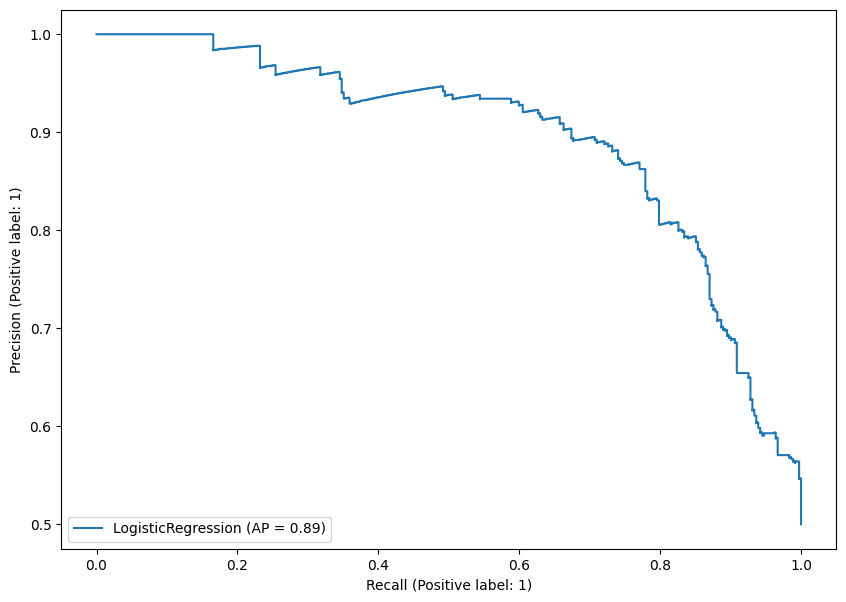

In [155]:
fig,ax = plt.subplots(1,1, figsize=(10,7))

PrecisionRecallDisplay.from_estimator(model, X_res[optcol], y_res, ax=ax)

plt.show()

In [157]:
y_prob = model.predict_proba(X_res[optcol])

precision, recall, threshold = precision_recall_curve(y_res, y_prob[:,1])

prc_df = pd.DataFrame(precision,columns=['Precision'])
prc_df['Recall'] = recall

nb_opt = prc_df[prc_df['Recall']>=.75].sort_values('Precision',ascending=False).iloc[1].name
pd.Series({'threshold':threshold[nb_opt],
           'precision':precision[nb_opt],
           'recall':recall[nb_opt]})


threshold    0.567565
precision    0.868750
recall       0.767956
dtype: float64

# Final Test

In [168]:
X_val = val.drop(columns='Survived')
y_val = val.Survived

X_val_proc = preproc_func(X_val,mode='eval').drop(columns=[*['ordcol__Sex','Ticket_14'],*zero_cols])
X_val = scaler.transform(X_val_proc)
X_val = pd.DataFrame(X_val,columns=X_val_proc.columns)

val_pred = model.predict(X_val[optcol])


print(f'auc: {roc_auc_score(y_val,val_pred)}')
print(f'recall: {recall_score(y_val,val_pred)}')
print(f'accuracy: {accuracy_score(y_val,val_pred)}')
print(f'precision: {precision_score(y_val,val_pred)}')

auc: 0.8266666666666667
recall: 0.82
accuracy: 0.8283582089552238
precision: 0.7454545454545455


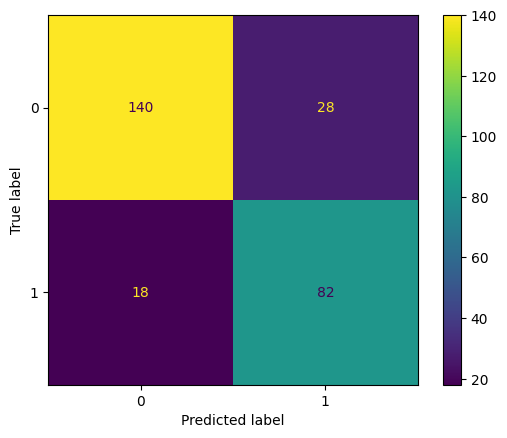

In [169]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_val, val_pred, labels=model.classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()